# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
isolasi = pd.read_csv('isolasi.csv')
icu = pd.read_csv('icu.csv')

isolasi.tail()

,Tanggal,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi
351,17 Nov 2021,4283,177,0.041326
352,18 Nov 2021,4279,198,0.046272
353,19 Nov 2021,4256,195,0.045818
354,20 Nov 2021,4256,196,0.046053
355,21 Nov 2021,4256,185,0.043468


In [3]:
icu.tail()

,Tanggal,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
351,17 Nov 2021,675,47,0.069630
352,18 Nov 2021,675,46,0.068148
353,19 Nov 2021,669,45,0.067265
354,20 Nov 2021,673,44,0.065379
355,21 Nov 2021,675,42,0.062222


In [4]:
print(isolasi.shape)
print(icu.shape)

(356, 4)
(356, 4)


In [5]:
print(isolasi.isna().sum())
print(icu.isna().sum())

Tanggal                      0
Total TT Isolasi             0
Total Pasien Isolasi         0
% Keterpakaian TT Isolasi    0
dtype: int64
Tanggal                  0
Total TT ICU             0
Total Pasien ICU         0
% Keterpakaian TT ICU    0
dtype: int64


In [6]:
data = isolasi.merge(icu, on='Tanggal')
data.head()

,Tanggal,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
0,1 Des 2020,6178,4849,0.784882,875,630,0.720000
1,2 Des 2020,6181,4866,0.787251,881,628,0.712826
2,3 Des 2020,6230,4908,0.787801,883,628,0.711212
3,4 Des 2020,6305,4985,0.790642,874,610,0.697941
4,5 Des 2020,6302,4960,0.787052,874,620,0.709382


In [7]:
# data.['Tanggal'].str.replace()
data['Tanggal'].replace(regex={'Mei': 'May',
                              'Agu': 'Aug',
                              'Okt': 'Oct',
                              'Des': 'Dec'}, inplace=True)

In [8]:
data['date'] = pd.to_datetime(data['Tanggal'], format='%d %b %Y')
data.set_index('date', inplace=True)
data.drop('Tanggal', axis=1, inplace=True)

In [9]:
data

,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
date,,,,,,
2020-12-01,6178,4849,0.784882,875,630,0.720000
2020-12-02,6181,4866,0.787251,881,628,0.712826
2020-12-03,6230,4908,0.787801,883,628,0.711212
2020-12-04,6305,4985,0.790642,874,610,0.697941
2020-12-05,6302,4960,0.787052,874,620,0.709382
...,...,...,...,...,...,...
2021-11-17,4283,177,0.041326,675,47,0.069630
2021-11-18,4279,198,0.046272,675,46,0.068148
2021-11-19,4256,195,0.045818,669,45,0.067265


In [10]:
data.describe()

,Total TT Isolasi,Total Pasien Isolasi,% Keterpakaian TT Isolasi,Total TT ICU,Total Pasien ICU,% Keterpakaian TT ICU
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,7597.514045,4034.311798,0.486000,1114.752809,632.867978,0.541665
std,1856.738462,2941.489659,0.304618,230.569547,367.195603,0.263028
min,4256.000000,172.000000,0.039659,669.000000,42.000000,0.062222
25%,6564.000000,1666.500000,0.193150,981.250000,341.500000,0.314173
50%,7375.500000,3861.500000,0.483492,1095.000000,634.500000,0.571124
75%,8288.250000,6045.250000,0.791518,1189.000000,834.250000,0.776967
max,11773.000000,10623.000000,0.939729,1651.000000,1484.000000,0.949442


# Modeling

## Identification

<AxesSubplot:xlabel='date', ylabel='Total Pasien Isolasi'>

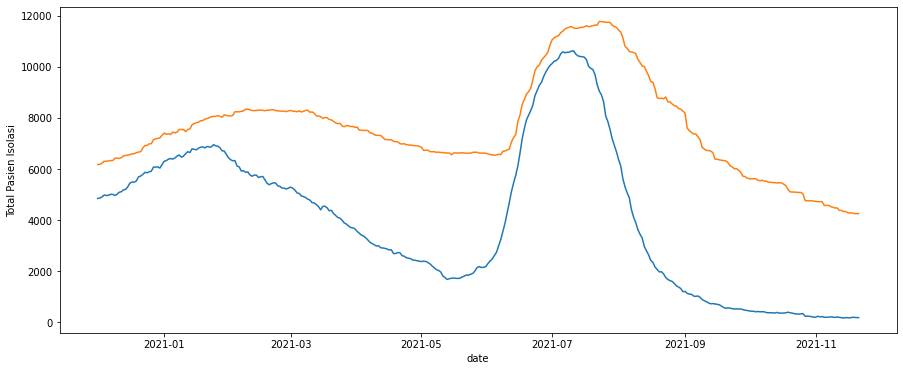

In [11]:
plt.figure(figsize=(15,6))

sns.lineplot(x=data.index,
            y='Total Pasien Isolasi',
            data=data)

sns.lineplot(x=data.index,
            y='Total TT Isolasi',
            data=data)

<AxesSubplot:xlabel='date', ylabel='Total Pasien ICU'>

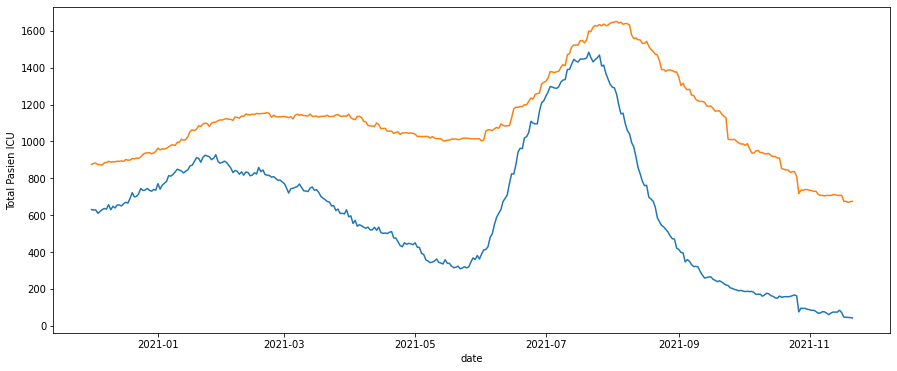

In [12]:
plt.figure(figsize=(15,6))

sns.lineplot(x=data.index,
            y='Total Pasien ICU',
            data=data)

sns.lineplot(x=data.index,
            y='Total TT ICU',
            data=data)

In [13]:
df_isolasi = data['Total Pasien Isolasi']
df_icu = data['Total Pasien ICU']

# mengambil data test sebanyak 30 hari

train_isolasi = df_isolasi[:-30]
test_isolasi = df_isolasi[-30:]

train_icu = df_icu[:-20]
test_icu = df_icu[-20:]

In [29]:
test_isolasi

date
2021-10-23    332
2021-10-24    322
2021-10-25    334
2021-10-26    343
2021-10-27    240
2021-10-28    245
2021-10-29    238
2021-10-30    226
2021-10-31    202
2021-11-01    207
2021-11-02    239
2021-11-03    215
2021-11-04    224
2021-11-05    200
2021-11-06    200
2021-11-07    203
2021-11-08    216
2021-11-09    205
2021-11-10    195
2021-11-11    211
2021-11-12    195
2021-11-13    185
2021-11-14    172
2021-11-15    186
2021-11-16    183
2021-11-17    177
2021-11-18    198
2021-11-19    195
2021-11-20    196
2021-11-21    185
Name: Total Pasien Isolasi, dtype: int64

### Dicky-Fuller Test

Tes yang paling umum untuk mengidentifikasi apakah deret waktu non-stasioner adalah tes Dicky-Fuller.

H0 = Data tidak Stasioner

In [14]:
isolasi_dft = adfuller(train_isolasi)
icu_dft = adfuller(train_icu)
# Print test statistic and P-value
print('Isolasi Test Statistics ',isolasi_dft[0])
print('Isolasi p-value ',isolasi_dft[1])

print('ICU Test Statistics ',icu_dft[0])
print('ICU p-value ',icu_dft[1])

Isolasi Test Statistics  -4.285595819470934
Isolasi p-value  0.0004704291056598787
ICU Test Statistics  -3.3791081491799426
ICU p-value  0.011692028531553302


Jika p-value lebih kecil dari 0.05, maka tolak H0.

Sehingga data Total Pasien Isolasi diasumsikan tidak stasioner dan data Total Pasien ICU diasumsikan Stasioner.

Harus dilakukan Differencing pada data Total Pasien Isolasi.

### Differencing

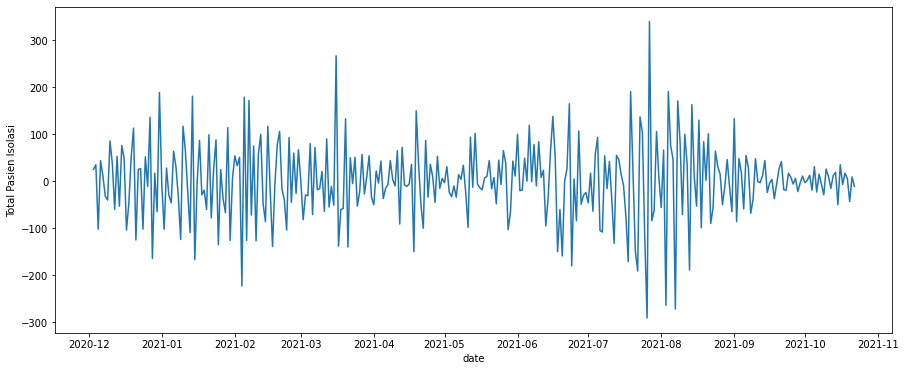

Isolasi Test Statistics  -5.047455555302007
Isolasi p-value  1.7862382094171996e-05


In [21]:
isolasi_diff = train_isolasi.diff().diff().dropna()

isolasi_diff_dft = adfuller(isolasi_diff)

plt.figure(figsize=(15,6))
sns.lineplot(x=isolasi_diff.index,
            y=isolasi_diff,
            data=isolasi_diff)
plt.show()

print('Isolasi Test Statistics ',isolasi_diff_dft[0])
print('Isolasi p-value ',isolasi_diff_dft[1])

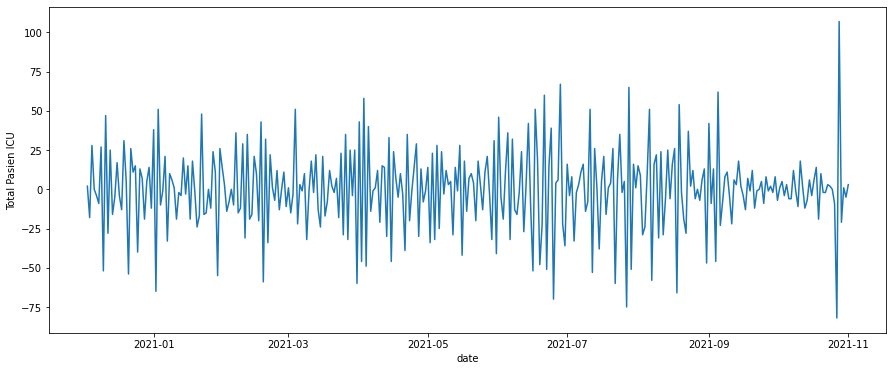

Isolasi Test Statistics  -9.966362663626194
Isolasi p-value  2.3014087344538014e-17


In [28]:
icu_diff = train_icu.diff().diff().dropna()

icu_diff_dft = adfuller(icu_diff)

plt.figure(figsize=(15,6))
sns.lineplot(x=icu_diff.index,
            y=icu_diff,
            data=icu_diff)
plt.show()

print('Isolasi Test Statistics ',icu_diff_dft[0])
print('Isolasi p-value ',icu_diff_dft[1])

Setelah dilakukan differencing datanya sudah stasioner dan sudah bisa digunakan untuk modeling.

### Plot ACF dan PACF

#### Plot ACF dan PACF Data Total Pasien Isolasi

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


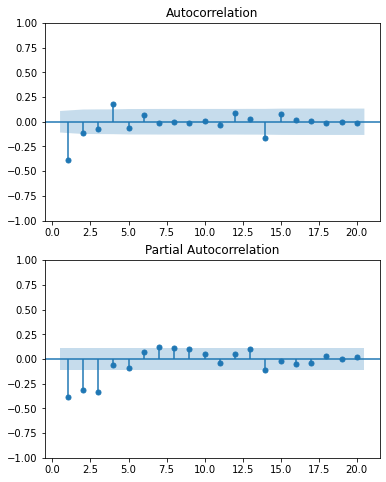

In [17]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
 
# Plot the ACF of savings on ax1
plot_acf(isolasi_diff, lags=20, zero=False, ax=ax1)
 
# Plot the PACF of savings on ax2
plot_pacf(isolasi_diff, lags=20, zero=False, ax=ax2)
 
plt.show()

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


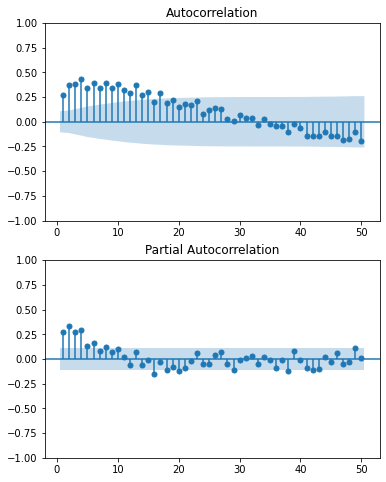

In [24]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
 
# Plot the ACF of savings on ax1
plot_acf(train_icu.diff().dropna(), lags=50, zero=False, ax=ax1)
 
# Plot the PACF of savings on ax2
plot_pacf(train_icu.diff().dropna(), lags=50, zero=False, ax=ax2)
 
plt.show()

## Estimation


### Total Pasien Isolasi

#### Penentuan Order berdasarkan RMSE

In [49]:
# Create empty list to store search results
order_rmse=[]

# Loop over p values
for p in [0, 1, 2, 4, 6, 8, 10]:
    # Loop over d values from 0-2
    for d in range(3):
        # Loop over q values from 0-2
        for q in range(3):
            try:
                # Create and fit ARMA(p,q) model
                model = SARIMAX(train_isolasi, order=(p,d,q), trend='c')
                results = model.fit()
                
                # Create forecast object
                forecast = results.get_forecast(steps=30)
 
                # Extract predicted mean attribute
                mean = forecast.predicted_mean
                
                #RMSE
                rmse = np.sqrt(mean_squared_error(test_isolasi, mean))

                # Print p, d, q, RMSE, AIC, BIC
                order_rmse.append((p,d,q,rmse,results.aic,results.bic))

            except:
                order_rmse.append((p,d,q,None,None,None))

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No fr

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No fr

In [50]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_rmse, 
                        columns=['p', 'd', 'q', 'RMSE', 'AIC', 'BIC'])
 
# Print order_df in order of increasing AIC
print(order_df.sort_values('RMSE').head())

     p  d  q        RMSE          AIC          BIC
53   8  2  2   25.368608  3656.540470  3701.909392
58  10  1  1   92.351738  3661.858079  3711.047806
41   6  1  2  118.689358  3664.876125  3702.714377
3    0  1  0  131.639337  4120.424918  4127.992568
35   4  2  2  134.665832  3666.102800  3696.348748


Setelah melihat nilai RMSE, AIC dan BIC dapat ditentukan model terbaik adalah ARIMA(8,2,2)

#### Fitting Model

In [51]:
# Create and fit model
model_isolasi_822 = SARIMAX(train_isolasi, order=(8,2,2), trend = 'c')
results_isolasi_822 = model_isolasi_822.fit()
 
# Print summary
print(results_isolasi_822.summary())

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                 
Dep. Variable:     Total Pasien Isolasi   No. Observations:                  326
Model:                 SARIMAX(8, 2, 2)   Log Likelihood               -1816.270
Date:                  Fri, 10 Dec 2021   AIC                           3656.540
Time:                          11:28:48   BIC                           3701.909
Sample:                      12-01-2020   HQIC                          3674.649
                           - 10-22-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1922      0.769      0.250      0.803      -1.315       1.699
ar.L1          1.1214      0.058     19.285      0.000       1.007       1.235
ar.L2         -0.3748      0.082    

### Total Pasien ICU

#### Penentuan Order berdasarkan RMSE

In [52]:
# Create empty list to store search results
order_rmse=[]

# Loop over p values 
for p in [0, 1, 2, 4]:
    for d in range(3):
        # Loop over q values from 0-4
        for q in range(5):
            try:
                # Create and fit ARMA(p,q) model
                model = SARIMAX(train_icu, order=(p,d,q), trend='c')
                results = model.fit()

                # Create forecast object
                forecast = results.get_forecast(steps=20)

                # Extract predicted mean attribute
                mean = forecast.predicted_mean

                #RMSE
                rmse = np.sqrt(mean_squared_error(test_icu, mean))

                # Print p, d, q, RMSE, AIC, BIC
                order_rmse.append((p,d,q,rmse,results.aic,results.bic))

            except:
                order_rmse.append((p,d,q,None,None,None))

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be us

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequen

In [53]:
# Construct DataFrame from order_rmse
order_df = pd.DataFrame(order_rmse, 
                        columns=['p', 'd', 'q','RMSE', 'AIC', 'BIC'])
 
# Print order_df in order of increasing RMSE
print(order_df.sort_values('RMSE').head())

    p  d  q      RMSE          AIC          BIC
10  0  2  0  9.208692  3129.420130  3137.042412
35  2  1  0  9.225497  2950.907838  2966.164360
50  4  1  0  9.272932  2901.163011  2924.047794
8   0  1  3  9.293548  2964.181942  2983.252595
7   0  1  2  9.631886  2978.345174  2993.601696


Setelah melihat nilai RMSE, AIC dan BIC dapat ditentukan model terbaik adalah ARIMA(4,1,0)

#### Fitting Model

In [54]:
# Create and fit model
model_icu_410 = SARIMAX(train_icu, order=(4,1,0), trend = 'c')
results_icu_410 = model_icu_410.fit()
 
# Print summary
print(results_icu_410.summary())

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:       Total Pasien ICU   No. Observations:                  336
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -1444.582
Date:                Fri, 10 Dec 2021   AIC                           2901.163
Time:                        11:34:40   BIC                           2924.048
Sample:                    12-01-2020   HQIC                          2910.287
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4297      1.015     -0.423      0.672      -2.420       1.560
ar.L1          0.0121      0.046      0.260      0.795      -0.079       0.103
ar.L2          0.1986      0.050      3.994      0.0

## Model diagnostic

### Total Pasien Isolasi

#### Diagnostic plots ARIMA (8,2,2) 

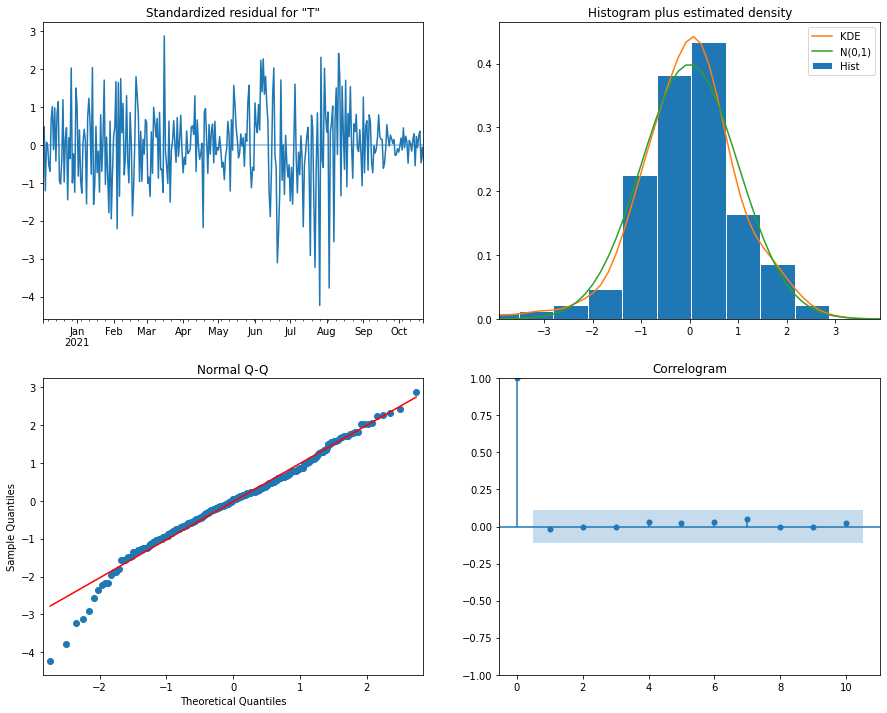

In [55]:
# Create the 4 diagostics plots
results_isolasi_822.plot_diagnostics(figsize=(15, 12))
plt.show()

### Total Pasien ICU

#### Diagnostic plots ARIMA (4,1,0)

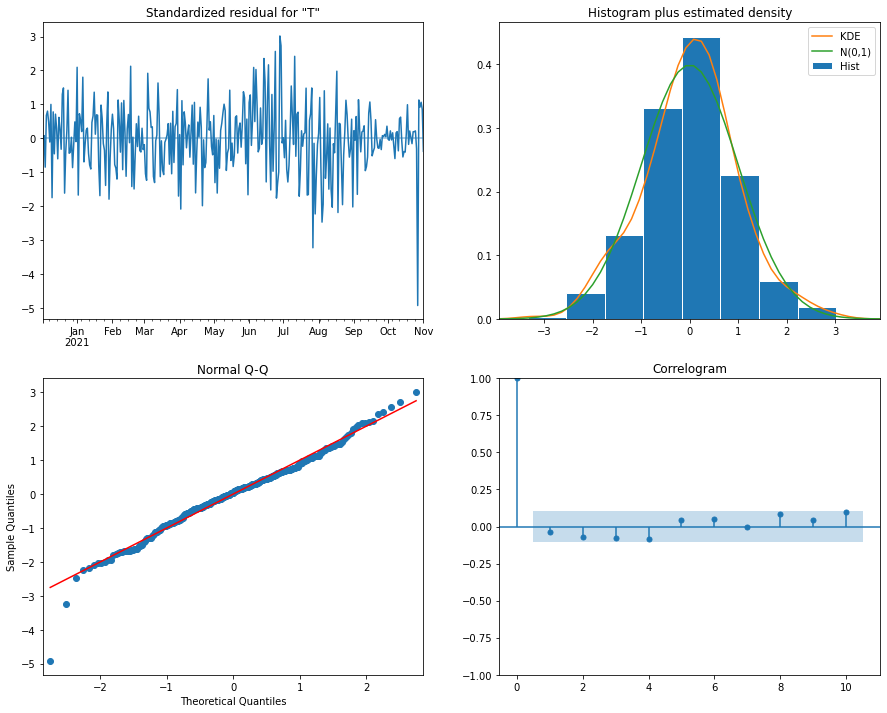

In [56]:
# Create the 4 diagostics plots
results_icu_410.plot_diagnostics(figsize=(15, 12))
plt.show()

## Evaluation

### Total Pasien Isolasi

#### Model ARIMA (8,2,2)

In [57]:
# Create forecast object
forecast_isolasi_822 = results_isolasi_822.get_forecast(steps=30)
 
# Extract predicted mean attribute
mean_isolasi_822 = forecast_isolasi_822.predicted_mean

#### Evaluasi

In [58]:
mse_isolasi_822 = np.sqrt(mean_squared_error(test_isolasi, mean_isolasi_822))

print('MSE of Isolasi ARIMA(8,2,2)', mse_isolasi_822)

MSE of Isolasi ARIMA(8,2,2) 25.36860776297876


In [59]:
# Create forecast object
forecast_object_isolasi = results_isolasi_822.get_forecast(steps=30)
 
# Extract predicted mean attribute
mean_isolasi = forecast_object_isolasi.predicted_mean

# Calculate the confidence intervals
conf_int_isolasi = forecast_object_isolasi.conf_int()
 
# Extract the forecast dates
dates_isolasi = mean_isolasi.index

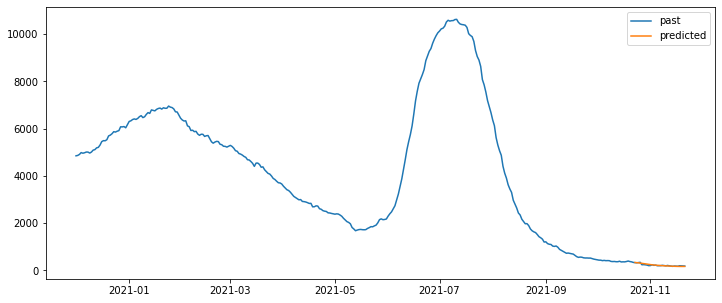

In [60]:
plt.figure(figsize=(12,5))
 
# Plot past CO2 levels
plt.plot(df_isolasi.index, df_isolasi, label='past')
 
# Plot the prediction means as line
plt.plot(dates_isolasi, mean_isolasi, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

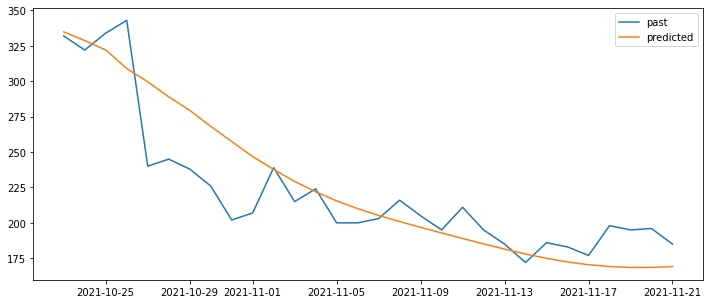

In [62]:
plt.figure(figsize=(12,5))

# Plot past CO2 levels
plt.plot(test_isolasi.index, test_isolasi, label='past')
 
# Plot the prediction means as line
plt.plot(dates_isolasi, mean_isolasi, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

### Total Pasien ICU

#### Model ARIMA (4,1,0)

In [63]:
# Create forecast object
forecast_icu_410 = results_icu_410.get_forecast(steps=20)
# Extract predicted mean attribute
mean_icu_410 = forecast_icu_410.predicted_mean

#### Evaluasi

In [64]:
mse_icu_410 = np.sqrt(mean_squared_error(test_icu, mean_icu_410))

print('MSE of ICU ARIMA(4,1,0)', mse_icu_410)

MSE of ICU ARIMA(4,1,0) 9.272932075784803


In [65]:
# Create forecast object
forecast_object_icu = results_icu_410.get_forecast(steps=20)
 
# Extract predicted mean attribute
mean_icu = forecast_object_icu.predicted_mean

# Calculate the confidence intervals
conf_int_icu = forecast_object_icu.conf_int()
 
# Extract the forecast dates
dates_icu = mean_icu.index

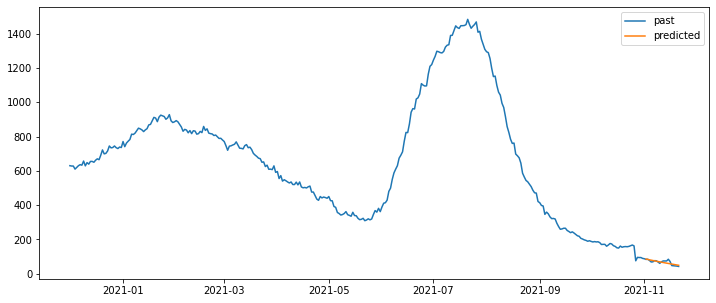

In [66]:
plt.figure(figsize=(12,5))
 
# Plot past CO2 levels
plt.plot(df_icu.index, df_icu, label='past')
 
# Plot the prediction means as line
plt.plot(dates_icu, mean_icu, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

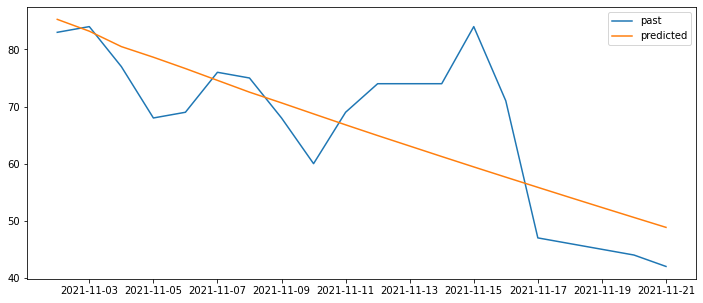

In [67]:
plt.figure(figsize=(12,5))

# Plot past CO2 levels
plt.plot(test_icu.index, test_icu, label='past')
 
# Plot the prediction means as line
plt.plot(dates_icu, mean_icu, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

## Forcasting

### Total Pasien Isolasi

In [30]:
model_isolasi = SARIMAX(df_isolasi, order=(8,2,2), trend='c')
results_isolasi = model_isolasi.fit()

# Create forecast object
forecast_isolasi = results_isolasi.get_forecast(steps=30)

# Extract predicted mean attribute
mean_isolasi_final = forecast_isolasi.predicted_mean

# Extract the forecast dates
dates_isolasi_final = mean_isolasi_final.index

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


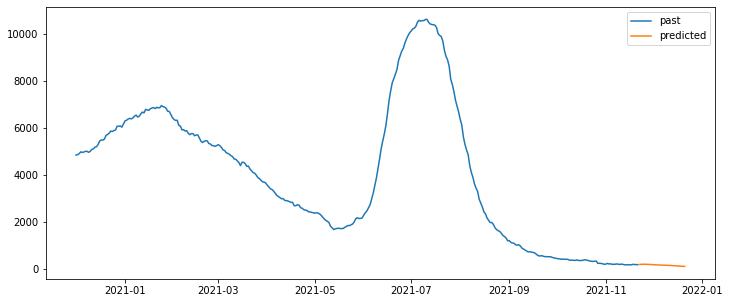

In [31]:
plt.figure(figsize=(12,5))
 
# Plot past CO2 levels
plt.plot(df_isolasi.index, df_isolasi, label='past')
 
# Plot the prediction means as line
plt.plot(dates_isolasi_final, mean_isolasi_final, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

In [32]:
df_isolasi_forecast = pd.concat([df_isolasi, mean_isolasi_final])

In [36]:
mean_isolasi_final.head()

2021-11-22    191.424235
2021-11-23    196.617420
2021-11-24    202.236519
2021-11-25    201.830130
2021-11-26    202.188088
Freq: D, Name: predicted_mean, dtype: float64

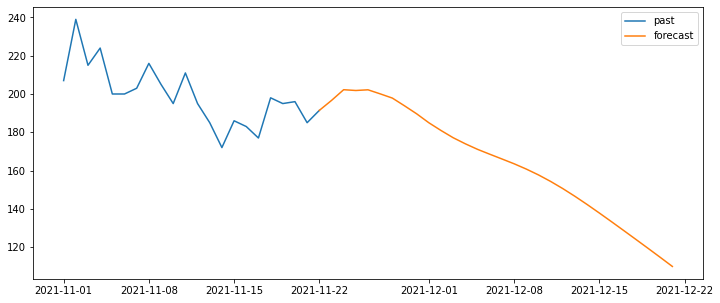

In [33]:
plt.figure(figsize=(12,5))
# Plot the prediction means as line
plt.plot(df_isolasi_forecast.loc['2021-11-01':'2021-11-22'].index, df_isolasi_forecast.loc['2021-11-01':'2021-11-22'], label = 'past')
plt.plot(df_isolasi_forecast.loc['2021-11-22':].index, df_isolasi_forecast.loc['2021-11-22':], label = 'forecast')
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

### Total Pasien ICU

In [37]:
model_icu = SARIMAX(df_icu, order=(4,1,0), trend='c')
results_icu = model_icu.fit()

# Create forecast object
forecast_icu = results_icu.get_forecast(steps=30)

# Extract predicted mean attribute
mean_icu_final = forecast_icu.predicted_mean

# Extract the forecast dates
dates_icu_final = mean_icu_final.index

c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\rahmatmamat\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


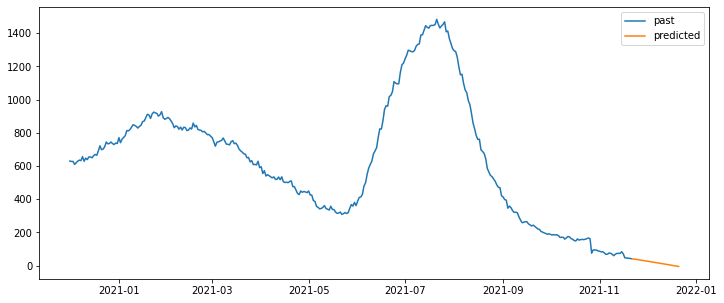

In [38]:
plt.figure(figsize=(12,5))
 
# Plot past CO2 levels
plt.plot(df_icu.index, df_icu, label='past')
 
# Plot the prediction means as line
plt.plot(dates_icu_final, mean_icu_final, label='predicted')
 
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

In [39]:
df_icu_forecast = pd.concat([df_icu, mean_icu_final])

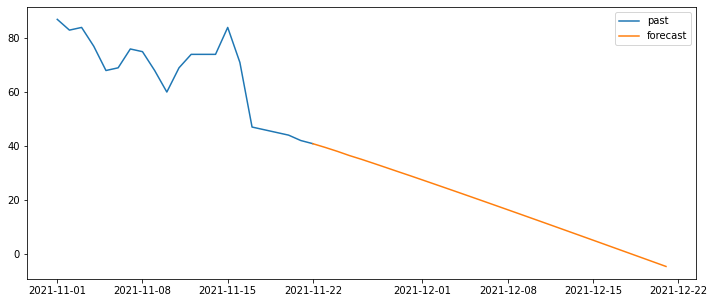

In [40]:
plt.figure(figsize=(12,5))
# Plot the prediction means as line
plt.plot(df_icu_forecast.loc['2021-11-01':'2021-11-22'].index, df_icu_forecast.loc['2021-11-01':'2021-11-22'], label = 'past')
plt.plot(df_icu_forecast.loc['2021-11-22':].index, df_icu_forecast.loc['2021-11-22':], label = 'forecast')
# # Shade between the confidence intervals
# plt.fill_between(conf_int.index, conf_int['lower Total Pasien Isolasi'], conf_int['upper Total Pasien Isolasi'], alpha=0.2)
 
# Plot legend and show figure
plt.legend()
plt.show()

In [41]:
df_final = pd.concat([df_isolasi_forecast, df_icu_forecast], axis=1, join='inner')
df_final = df_final.rename({0: 'Total Pasien Isolasi', 1: 'Total Pasien ICU'}, axis=1)
df_final

,Total Pasien Isolasi,Total Pasien ICU
2020-12-01,4849.000000,630.000000
2020-12-02,4866.000000,628.000000
2020-12-03,4908.000000,628.000000
2020-12-04,4985.000000,610.000000
2020-12-05,4960.000000,620.000000
...,...,...
2021-12-17,128.673569,1.748342
2021-12-18,124.039154,0.120333
2021-12-19,119.372389,-1.509379
2021-12-20,114.663458,-3.140619


In [42]:
df_final = df_final.astype(int)
df_final[df_final < 0] = 0
df_final

,Total Pasien Isolasi,Total Pasien ICU
2020-12-01,4849,630
2020-12-02,4866,628
2020-12-03,4908,628
2020-12-04,4985,610
2020-12-05,4960,620
...,...,...
2021-12-17,128,1
2021-12-18,124,0
2021-12-19,119,0
2021-12-20,114,0


In [43]:
df_final['TT Isolasi Batas Atas'] = round(df_final['Total Pasien Isolasi']/0.6)
df_final['TT Isolasi Batas Bawah'] = round(df_final['Total Pasien Isolasi']/0.85)
df_final['TT ICU Batas Atas'] = round(df_final['Total Pasien ICU']/0.6)
df_final['TT ICU Batas Bawah'] = round(df_final['Total Pasien ICU']/0.85)

In [44]:
df_final

,Total Pasien Isolasi,Total Pasien ICU,TT Isolasi Batas Atas,TT Isolasi Batas Bawah,TT ICU Batas Atas,TT ICU Batas Bawah
2020-12-01,4849,630,8082.0,5705.0,1050.0,741.0
2020-12-02,4866,628,8110.0,5725.0,1047.0,739.0
2020-12-03,4908,628,8180.0,5774.0,1047.0,739.0
2020-12-04,4985,610,8308.0,5865.0,1017.0,718.0
2020-12-05,4960,620,8267.0,5835.0,1033.0,729.0
...,...,...,...,...,...,...
2021-12-17,128,1,213.0,151.0,2.0,1.0
2021-12-18,124,0,207.0,146.0,0.0,0.0
2021-12-19,119,0,198.0,140.0,0.0,0.0
2021-12-20,114,0,190.0,134.0,0.0,0.0


In [45]:
pred_iso_sorted = df_final.loc['2021-11-22':].sort_values('TT Isolasi Batas Atas', ascending=False)
pred_icu_sorted = df_final.loc['2021-11-22':].sort_values('TT ICU Batas Atas', ascending=False)

In [54]:
print(pred_iso_sorted['Total Pasien Isolasi'].head())
print(pred_icu_sorted['Total Pasien ICU'].head())

2021-11-24    202
2021-11-26    202
2021-11-25    201
2021-11-27    200
2021-11-28    197
Name: Total Pasien Isolasi, dtype: int32
2021-11-22    40
2021-11-23    39
2021-11-24    37
2021-11-25    36
2021-11-26    34
Name: Total Pasien ICU, dtype: int32


In [46]:
print('Rekomendasi Jumlah Tempat Tidur Isolasi pada periode 22-11-2021 sampai 21-12-2021 adalah {} - {}.'.format(
    pred_iso_sorted['TT Isolasi Batas Bawah'][0],
    pred_iso_sorted['TT Isolasi Batas Atas'][0]
))

print('Rekomendasi Jumlah Tempat Tidur ICU pada periode 22-11-2021 sampai 21-12-2021 adalah {} - {}.'.format(
    pred_icu_sorted['TT ICU Batas Bawah'][0],
    pred_icu_sorted['TT ICU Batas Atas'][0]
))

Rekomendasi Jumlah Tempat Tidur Isolasi pada periode 22-11-2021 sampai 21-12-2021 adalah 238.0 - 337.0.
Rekomendasi Jumlah Tempat Tidur ICU pada periode 22-11-2021 sampai 21-12-2021 adalah 47.0 - 67.0.


### Save dataframe to CSV

In [115]:
df_final.to_csv('df_final.csv', sep ='\t')

### Save Model

In [119]:
# save the model to disk
joblib.dump(results_icu, 'final_model_icu.pkl')
joblib.dump(results_isolasi, 'final_model_isolasi.pkl')
 
# some time later...
 
# load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)

['final_model_isolasi.pkl']